Relier chaque adresse a son client (jointure)
Choisir la target nommée class (1:fraud/0:No soucis)
Encoder les données catégoriques (labelEncoder de sklearn)
Entrainer avec un random forest
plotter la feature importance

# TP Fraud

## Librairies

In [1]:
import pandas as pd
import ipaddress as ipa
import pandasql as psql
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import confusion_matrix

## Datasets

In [2]:
fraud = pd.read_csv("/home/vincent/Hitema/datasets/Fraud_Data.csv")
ip = pd.read_csv("/home/vincent/Hitema/datasets/IpAddress_to_Country.csv")

## Infos de fraud

In [3]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [4]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## Infos de IP

In [5]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [6]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Gestion des valeurs manquantes

In [7]:
fraud = fraud.dropna()
ip = ip.dropna()

## Test d'une utilisation de la lib ipadress pour essayer de convertir nos adresses de float à IPV4 (str)

In [8]:
ipa.ip_address(int(fraud['ip_address'].iloc[0]))

IPv4Address('43.173.1.96')

## Requête SQL incluant la jointure des deux DF (LIMIT à 20 pour limiter le temps d'éxécution)

In [9]:
query = "SELECT * FROM fraud, ip WHERE fraud.ip_address BETWEEN ip.lower_bound_ip_address AND ip.upper_bound_ip_address;"

## Grâce à la lib Pandasql on passe la requete et on retourne un nouveau DF

In [10]:
df = psql.sqldf(query, locals())
df = df.drop(columns={'signup_time', 'purchase_time', 'user_id', 'device_id'})
df.head()

,purchase_value,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
0,34,SEO,Chrome,M,39,7.327584e+08,0,7.298089e+08,734003199,Japan
1,16,Ads,Chrome,F,53,3.503114e+08,0,3.355443e+08,352321535,United States
2,15,SEO,Opera,M,53,2.621474e+09,1,2.621440e+09,2621505535,United States
3,39,Ads,Safari,M,45,4.155831e+08,0,4.154982e+08,415629311,United States
4,42,Ads,Chrome,M,18,2.809315e+09,0,2.809266e+09,2809331711,Canada


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129146 entries, 0 to 129145
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   purchase_value          129146 non-null  int64  
 1   source                  129146 non-null  object 
 2   browser                 129146 non-null  object 
 3   sex                     129146 non-null  object 
 4   age                     129146 non-null  int64  
 5   ip_address              129146 non-null  float64
 6   class                   129146 non-null  int64  
 7   lower_bound_ip_address  129146 non-null  float64
 8   upper_bound_ip_address  129146 non-null  int64  
 9   country                 129146 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 9.9+ MB


## Encodage des données catégoriques avec LabelEncoder

In [12]:
le = LE()
df['source'] = le.fit_transform(df['source'])
df['browser'] = le.fit_transform(df['browser'])
df['sex'] = le.fit_transform(df['sex'])
df['country'] = le.fit_transform(df['country'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129146 entries, 0 to 129145
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   purchase_value          129146 non-null  int64  
 1   source                  129146 non-null  int64  
 2   browser                 129146 non-null  int64  
 3   sex                     129146 non-null  int64  
 4   age                     129146 non-null  int64  
 5   ip_address              129146 non-null  float64
 6   class                   129146 non-null  int64  
 7   lower_bound_ip_address  129146 non-null  float64
 8   upper_bound_ip_address  129146 non-null  int64  
 9   country                 129146 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 9.9 MB


## Séparation X & Y

In [13]:
y = df['class']
x = df.drop(columns='class')
x.shape, y.shape

((129146, 9), (129146,))

## Train test split

In [14]:
splits = tts(x, y, stratify=y, random_state=2)
x_tr, x_te, y_tr, y_te = splits

## Fonction de calcul de l'accuracy

In [15]:
def get_accuracy(preds, target):
    m = target.shape[0] # nombre d'exemples
    total_correct = (preds == target).sum()
    accuracy = total_correct / m
    return str(round(accuracy * 100, 2)) + "%"

## Prédiction Random Forest

In [16]:
rf = RandomForestClassifier()
rf.fit(x_tr, y_tr)
preds = rf.predict(x_te)
get_accuracy(preds, y_te)

'95.21%'

## Visualtion de la Features Importance

In [17]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [18]:
names = [x_te.columns[i] for i in indices]

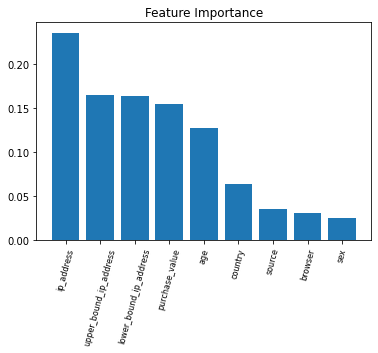

In [19]:
plt.bar(range(x_te.shape[1]), importances[indices])
plt.xticks(range(x_te.shape[1]), names, rotation=75, fontsize = 8)
plt.title("Feature Importance")
plt.show()

## ROC / AUC

In [24]:
proba = confusion_matrix(y_te, preds)

In [25]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

In [27]:
try:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_te, proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
except ValueError as err:
    print(err)

Found input variables with inconsistent numbers of samples: [32287, 2]


In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), proba[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()